In [14]:
# Usual imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# OpenCV
import cv2

# Keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Cleverhans
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

# Other modules
from pathlib import Path
from glob import glob
from tqdm.notebook import tqdm
from plot_keras_history import plot_history

We now load the data that will be used for our models

In [3]:
DATA_FOLDER = Path('../data')
IMG_FOLDER = Path(DATA_FOLDER / 'tsrd-train')
ANNOTATIONS = Path(DATA_FOLDER / 'TsignRecgTrain4170Annotation.txt')
COL_NAMES = ['filename','width','height','x1','y1','x2','y2','label']
MODEL_FOLDER = Path('../Part_1')
MODEL = Path(MODEL_FOLDER / 'chinese_traffic_sign_classifier_v1.h5')

Let's load the images from the dataset, keeping only the ones labeled **0** or **1**

In [6]:
images = glob(str(IMG_FOLDER) + '/*.png')
IMG_SIZE = (134,128)

dataset = []
labels = []

df = pd.read_csv(ANNOTATIONS, names=COL_NAMES, sep=';', header=None, index_col=False)

# Probably a better approach: filter all rows in the csv, then load only corresponding images...
for idx in range(len(images)):
    # get label specific to this image
    full_img_path = images[idx]
    filename = Path(full_img_path).name
    row = df[df['filename'] == filename]
    label = row['label'].values[0]
    if label == 0 or label == 1:
        
        img_bgr = cv2.imread(full_img_path)
        image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE)
        image = img_to_array(image)
        dataset.append(image)
        labels.append(label)

print(f'There are {len(dataset)} images in teh dataset')
        

There are 158 images in teh dataset


Let's now normalize the images, categorize the labels and split into training and validation sets

In [8]:
dataset = np.array(dataset) / 255.0
labels = to_categorical(labels)

(train_X, valid_X, train_Y, valid_Y) = train_test_split(dataset, labels, test_size=0.2)

We now define a model similar to the one trained in the very first project, but working with only the first two classes of the dataset

In [15]:
def create_model(input_dims, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_dims))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Conv2D(32, (5, 5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Flatten())  
    model.add(Dense(64, activation='relu',))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
     
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

student = create_model(train_X[0,:].shape, train_Y.shape[1])

Ok, we are now ready to train the model. We will use an Early Stopping callback and will play a bit with the batch size

In [16]:
IMAGE_SIZE = (134,128)
BS = 128
EPOCHS = 100

es = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1,
                   restore_best_weights=True, mode='min')

history = student.fit(train_X, train_Y, batch_size=BS, epochs=EPOCHS, callbacks=[es],
                      validation_data=(valid_X, valid_Y))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.7564 - accuracy: 0.2698 - val_loss: 0.5090 - val_accuracy: 0.7812
Epoch 2/100
1/1 [==============================] - 1s 901ms/step - loss: 0.5673 - accuracy: 0.7381 - val_loss: 0.5304 - val_accuracy: 0.7812
Epoch 3/100
1/1 [==============================] - 1s 849ms/step - loss: 0.5561 - accuracy: 0.7381 - val_loss: 0.5202 - val_accuracy: 0.7812
Epoch 4/100
1/1 [==============================] - 1s 854ms/step - loss: 0.5990 - accuracy: 0.7381 - val_loss: 0.5752 - val_accuracy: 0.7812
Epoch 5/100
1/1 [==============================] - 1s 890ms/step - loss: 0.5892 - accuracy: 0.7381 - val_loss: 0.4923 - val_accuracy: 0.7812
Epoch 6/100
1/1 [==============================] - 1s 948ms/step - loss: 0.5402 - accuracy: 0.7381 - val_loss: 0.4840 - val_accuracy: 0.7812
Epoch 7/100
1/1 [==============================] - 1s 868ms/step - loss: 0.5167 - accuracy: 0.7381 - val_loss: 0.4715 - val_accuracy: 0.7812
Epoch 8/100
1/1 

Epoch 59/100
1/1 [==============================] - 1s 868ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 60/100
1/1 [==============================] - 1s 899ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 61/100
1/1 [==============================] - 1s 888ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 62/100
1/1 [==============================] - 1s 850ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 63/100
1/1 [==============================] - 1s 886ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 64/100
1/1 [==============================] - 1s 893ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 1.0000
Epoch 65/100
1/1 [==============================] - 1s 908ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 

Let's now plot the loss and accuracy curves, and compute the accuracy on the validation data

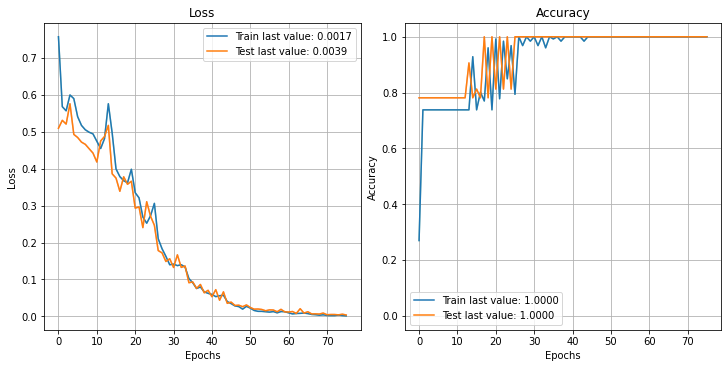

In [18]:
plot_history(history.history)
plt.show()

In [20]:
pred = student.predict(valid_X)
acc = np.sum(np.argmax(pred, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
print(f"Accuracy on input dataset: {acc * 100:.2f}%")

Accuracy on input dataset: 100.00%


As expected, the accuracy is very high on the simple dataset with only two classes. Let's proceed by creating some corrupted inputs, using FGSM method.

In [24]:
EPSILON = 0.06

valid_X_fgsm = fast_gradient_method(student, valid_X, EPSILON, np.inf)

Finally, we compute the accuracy of the student model on the corrupted data

In [25]:
pred_fgsm = student.predict(valid_X_fgsm)
acc_fgsm = np.sum(np.argmax(pred_fgsm, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
print(f"Accuracy on fgsm-corrupted dataset: {acc_fgsm * 100:.2f}%")

Accuracy on fgsm-corrupted dataset: 68.75%
